<a href="https://colab.research.google.com/github/prasann25/colab/blob/main/10_time_series_forecasting_with_tensorflow_milestone_proj3_bitpredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Time series forecasting fundamentals with TensorFlow + Milestone Project 3 : BitPredict

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

**Note** : This is not a financial advice.

Links to understand some practical references:-
* All resources : https://github.com/mrdbourke/tensorflow-deep-learning

* https://dev.mrdbourke.com/tensorflow-deep-learning/

* https://eng.uber.com/forecasting-introduction/

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of Bitcoin, we downloaded the data from here :
https://www.coindesk.com/price/bitcoin

In [1]:
!nvidia-smi -L

GPU 0: Tesla P4 (UUID: GPU-a3e5d299-2bb6-d469-ed16-6255fb0461fa)


In [2]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv

--2021-08-25 01:22:52--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2021-08-25 01:22:53 (7.16 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [3]:
# Import with pandas
import pandas as pd
# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas column 1 is a datetime
df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
# How many samples do we have ?
len(df)

2787

In [6]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


We've collected the historical price of Bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can thousands to tens of thousands to millions)

A smaller number of samples is something you'll often run into with time series data problems.

> **Note** : The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one samples per dat meaning we'll get 365 samples per year.

In [7]:
# Only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)" : "Price"})
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


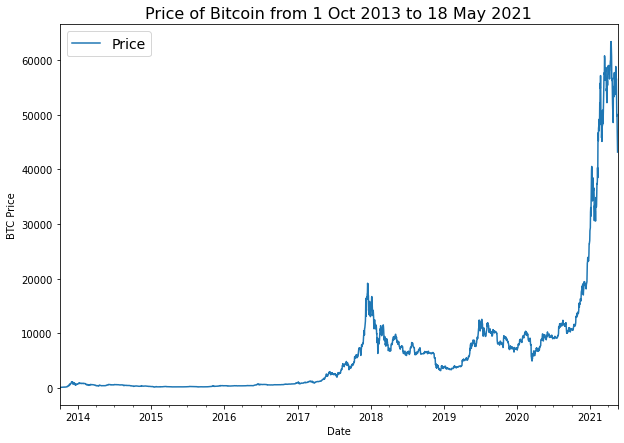

In [8]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14);

## Importing time series data with Python's CSV module

In [9]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f :
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader :
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates (not string)
    btc_price.append(float(line[2])) # Get closing price as float

In [10]:
timesteps [:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

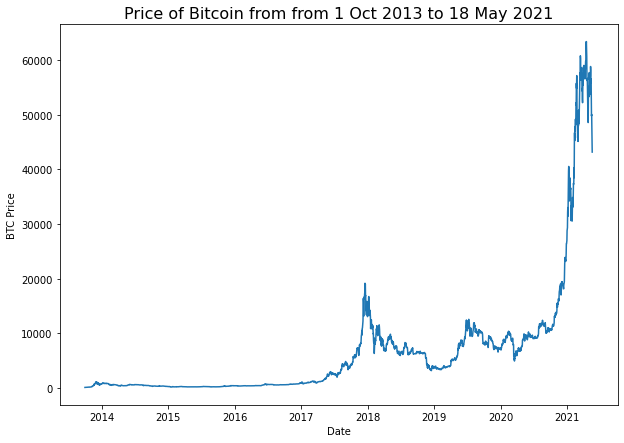

In [11]:
# Plot from CSV
import matplotlib.pyplot as plt
#import numpy as np
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.xlabel("Date");
#plt.legend(fontsize=14);

## Format data part 1 : Create train and test sets of our time series data

### Creating train and test sets with time series data ( the wrong way)

In [12]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000', '2013-10-06T00:00:00.000000000',
        '2013-10-07T00:00:00.000000000', '2013-10-08T00:00:00.000000000',
        '2013-10-09T00:00:00.000000000', '2013-10-10T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
        121.795  , 123.033  , 124.049  , 125.96116]))

In [13]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(timesteps, # dates
                                                    prices, # BTC prices
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

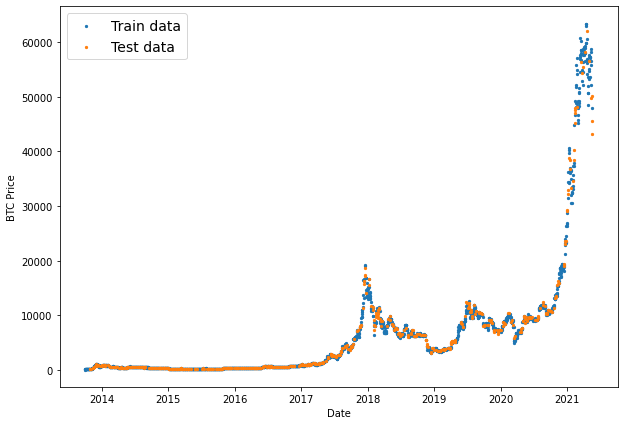

In [14]:
# Let's plot wrong train and test split
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label="Train data")
plt.scatter(X_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

### Create train and test sets for time series (the right away)

In [15]:
# Right way to create train/test sets for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test - you cna change these value as needed e.g  90/10, 95/5

# Create train data splits(everything before the split)
X_train, y_train = timesteps[ : split_size], prices[ : split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size : ], prices[split_size : ]

len(X_train), len(X_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

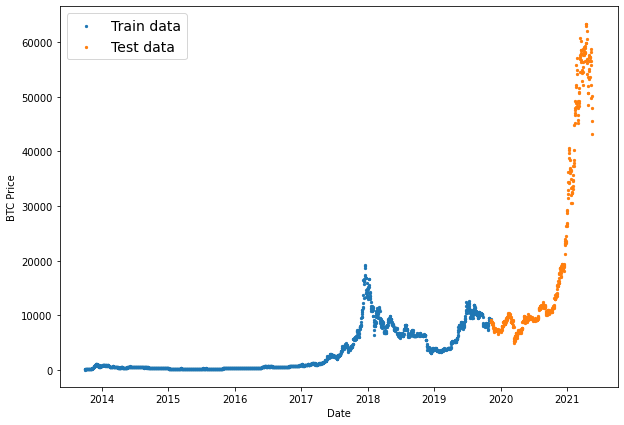

In [16]:
# Plot correctly made train and test data
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5 , label="Train data")
plt.scatter(X_test, y_test, s= 5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.show();

## Creating a plotting function

Typing plotting function is tedious , let's functionalize it.

In [17]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None) :
  """
  Plots timesteps ( a series of points in time) against values (a series of value across timesteps).
  
  Parameters
  ----------
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value wil index from start of timestamp & values)
  end : where to end the plot(similar to start but for the end)
  label : label to show on plot about values, default None
  """

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label :
    plt.legend(fontsize = 14) # make label bigger
  plt.grid(True)



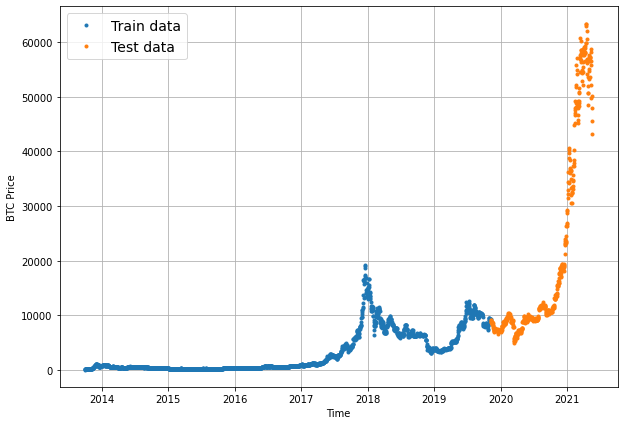

In [18]:
# Test our plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps = X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with :
* **Horizon** = number of timesteps into the future we're going to predict
* Window size = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running :-
* 0	Naïve model (baseline)
* 1	Dense model,	horizon = 1, window = 7
* 2	Same as 1,	horizon = 1, window =	30
* 3	Same as 1,	horizon = 7, window =	30
* 4	Conv1D
* 5	LSTM
* 6	Same as 1 (but with multivariate data)
* 7	N-BEATs Algorithm
* 8	Ensemble (multiple models optimized on different loss functions)
* 9	Future prediction model (model to predict future values)
* 10	Same as 1 (but with turkey 🦃 data introduced)

## Model 9 : Naive forecast(baseline)

The formula looks like this :
$$\hat{y}_{t} = y_{t-1}$$

In English :
> The prediction at timestep t (y-hat) is equal to the value at timestamp t-1 (previous timestep) this is for a horizon of 1.

References : https://otexts.com/fpp3/simple-methods.html

In [19]:
y_test[:10]

array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
       8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
       8500.64355816, 8469.2608989 ])

In [20]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

In [21]:
len(y_test), len(naive_forecast), y_test[-10:], naive_forecast[-10:]

(558,
 557,
 array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
        52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
        45604.61575361, 43144.47129086]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

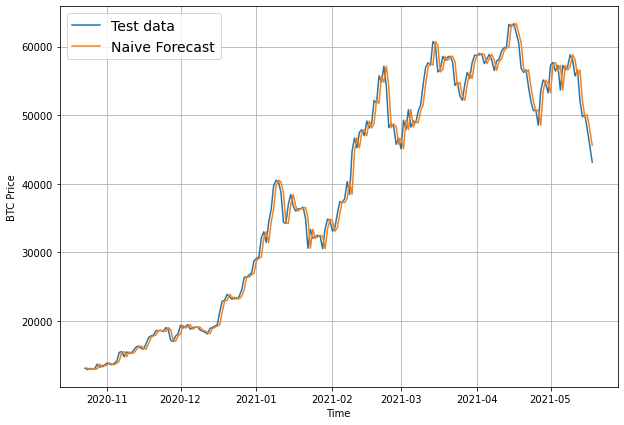

In [22]:
plt.figure(figsize=(10, 7))

#plot_time_series(timesteps=X_train, values=y_train, label="Train data")
plot_time_series(timesteps=X_test, values=y_test, start=350, format="-", label="Test data")
plot_time_series(timesteps=X_test[1:], values=naive_forecast, start=350, format="-", label="Naive Forecast")

> **Exercise** : Spend 10 minutes reading the simple forecasts chapter of Forecasting: Principles in Practice. And have a search to find out the naive forecast is hard to beat, does the term auto-regressive comes up?
 https://otexts.com/fpp3/simple-methods.html

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting) :
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics , **lower is better**, for example , an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is : **how do our model's forecast(y_pred) compare against the actual values(y_true or ground truth values) ?**


> **Resources** For a deeper dive on the various kinds of time series forecasting methods, see, please refer to 5.8 on the book https://otexts.com/fpp3/accuracy.html#accuracy

In [23]:
import tensorflow as tf


In [24]:
# MASE implementation 
def mean_absolute_scaled_error(y_true, y_pred) :
  """
  Implement MASE (assuming no seasonality of data).
  """
  # For future forecast experiments, 
  #if the function mean_absolute_scaled_error returns > 1 , means its worse than Naive forecast
  # if < 1, means its better than 1.
  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast(no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # our seasonlity is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [25]:
# Evaluating our naive forecast baseline, it should return 1
mean_absolute_scaled_error(y_true = y_test[1:],
                           y_pred = naive_forecast).numpy()

0.9995699939182624

## Create Evaluation metrics

In [26]:
# Create a function to take in model predictions and truth value and return eveluation metrics

def evaluate_preds(y_true, y_pred) :
  """
  Compute all evaluation metrics
  Returns :
  dictionary with all evaluation metrics values
  """
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {
      "mae" : mae.numpy(),
      "mse": mse.numpy(),
      "rmse" : rmse.numpy(),
      "mape" : mape.numpy(),
      "mase": mase.numpy()}

That's one good looking evaluation function !
Let's now see if it works...

In [27]:
# Evaluate Naive forecast (baseline)
naive_results = evaluate_preds(y_true = y_test[1:], 
                               y_pred = naive_forecast)
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

In [28]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [29]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737226>

In [30]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other models you can use for baselines and for actual forecasts

In this notebook, we're focused on TensorFlow and deep learning models.
However, there are plenty of time series that you could get a learning on 

https://dev.mrdbourke.com/tensorflow-deep-learning/10_time_series_forecasting_in_tensorflow/#Other-kinds-of-time-series-forecasting-models-which-can-be-used-for-baselines-and-actual-forecasts



Check out the ones by Facebook, LinkedIn

* https://github.com/facebookresearch/Kats
* https://github.com/linkedin/greykite



## Format Data Part 2: Windowing our dataset

Why do we window?
We window our timeseries dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [31]:
btc_price[:8]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033]

In [32]:
# What we want to do with our Bitcoin data
print(f"We want to use: {btc_price[:7]} to predict this : {btc_price[7]}")

We want to use: [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict this : 123.033


In [33]:
# Let's setup global variables for window and horizon size

HORIZON = 1 # predict next 1 day
WINDOW_SIZE = 7 # use the past week of Bitcoin data to make predictions

In [34]:
# Create function to label windowed data

def get_labelled_windows(x, horizon = HORIZON) :
  """
  Create labels for windowed dataset.
   E.g. if horizon =1
   Input: [0, 1, 2, 3, 4, 5, 6, 7] -> Output: ([0, 1, 2, 3, 4, 5, 6], [7]) 
  """
  return x[:, :-horizon], x[:, -horizon: ]

In [35]:
# Test out the window labelling function
test_window , test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window : {tf.squeeze(test_window).numpy()} -> Label : {tf.squeeze(test_label).numpy()} ")

Window : [0 1 2 3 4 5 6] -> Label : 7 


In [36]:
tf.expand_dims(tf.range(8), axis=0)

<tf.Tensor: shape=(1, 8), dtype=int32, numpy=array([[0, 1, 2, 3, 4, 5, 6, 7]], dtype=int32)>


Prepare the data using the sliding window approach.

We've got a way to label our windowed data. 
However, this only works on a small scale.
We need a way to do the above across our entire time series.

We could do this with Python for loops, however, for large time series, that'd be quite low.

To speed things up, we will leverage NumPy's array indexing - https://numpy.org/doc/stable/reference/arrays.indexing.html

Our function will :
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example :
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2. ) to index on a target series (e.g. the historical price of Bitcoin)
4. Use our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon


> **Resources** :-
The function here has been adapted from the following article:
https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5


In [37]:
import numpy as np
# 1. Create function to view NumPy arrays as windows

def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON) :

  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size(add the horizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size + horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus 1 account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size + horizon -1)), axis=0).T # Create 2D array of windows of size window_size
  #print(f"Window Indexes :\n {window_indexes, window_indexes.shape}")

  #3 . Index on the target array (a time series ) with 2D array of multiple window steps
  windowed_array = x[window_indexes]
  #print(f"Windowed_array : {windowed_array}")

  #4. Get the labelled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels




In [38]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [39]:
# View the first 3 windows/labels
for i in range(3) :
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [40]:
# View the last 3 windows/labels
for i in range(3) :
  print(f"Window : {full_windows[i-3]} -> Label : {full_labels[i-3]}")

Window : [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676] -> Label : [47885.62525472]
Window : [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472] -> Label : [45604.61575361]
Window : [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361] -> Label : [43144.47129086]


In [41]:
prices[-1]

43144.471290860296

> **Note** : There is a function which does similar to above in tf.keras.preprocessing, an extension could be to try and replicate what we've done using the pre-made function:
https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

## Turning windows into training and test sets

In [42]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2) :

  """
  Split matching pairs of windows and labels into train and test splits
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train 20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]

  return train_windows, test_windows, train_labels, test_labels


In [43]:
# Get train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

In [44]:
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [45]:
len(full_windows) * 0.8

2224.0

In [46]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [47]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[: -HORIZON -1]), y_train[WINDOW_SIZE:])

True

In [48]:
np.squeeze(train_labels[:5]).shape

(5,)

## Making a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apple to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load an evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following :-
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint




In [49]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename

def create_model_checkpoint(model_name, save_path="model_experiments") :
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name),
                                            verbose=0, # only output a limited  amout of text
                                            monitor="val_loss", # default value
                                            save_best_only=True)

## Model 1 : Dense model(window = 7, horizon = 1)

Our first deep model is going to be a simple dense model  :
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation(no activation)
* Adam optimization and MAE loss function
* Batch size of 128 ( previously we've used 32)
* Run for 100 epochs 


Why these values ?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practitioner(you!) can adjust themselves

* **Parameters** = also called weights are values a model learn on its own

** Since our dataset is smaller, we can increase the batch size and run for more epochs



In [50]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct model
model_1 = tf.keras.Sequential([
        layers.Dense(128, activation="relu"),
        layers.Dense(HORIZON, activation="linear")  # activation ="linear" same as no activation, pass thru activation layer and do nothing
        ], name="model_1_dense") # name our model so we can save it

# 2. Compile
model_1.compile(loss="mae",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["mae", "mse"])

# 3. Fit the model
model_1.fit(x= train_windows, 
            y = train_labels,
            epochs=100,
            verbose = 1,
            batch_size = 128,
            validation_data = (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name = model_1.name)])

Epoch 1/100
18/18 [==============================] - 3s 11ms/step - loss: 780.3455 - mae: 780.3455 - mse: 2312725.7500 - val_loss: 2279.6528 - val_mae: 2279.6528 - val_mse: 12772731.0000
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 2/100
18/18 [==============================] - 0s 4ms/step - loss: 247.6756 - mae: 247.6756 - mse: 285481.1875 - val_loss: 1005.9992 - val_mae: 1005.9992 - val_mse: 3441833.5000
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 188.4116 - mae: 188.4116 - mse: 171891.5938 - val_loss: 923.2863 - val_mae: 923.2863 - val_mse: 2868221.2500
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 169.4340 - mae: 169.4340 - mse: 151700.5625 - val_loss: 900.5872 - val_mae: 900.5872 - val_mse: 2683715.7500
INFO:tensorflow:Assets written to: model_ex

In [51]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 585.9752 - mae: 585.9752 - mse: 1197801.2500


[585.9751586914062, 585.9751586914062, 1197801.25]

In [52]:
# load in saved best performig model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.9510 - mae: 568.9510 - mse: 1171744.0000


[568.9510498046875, 568.9510498046875, 1171744.0]

## Making forecast with a model (on the test dataset)


To make "forecasts" on the test dataset (note : these won't be actual forecasts, they're only pseudo forecast because actual forecasts are into the future). Let's write a function to :
1. Take in a train mdoel
2. Takes in some input data(same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method.
4. Returns the predictions

In [53]:
def make_preds(model, input_data) :
  """
  Uses model to make predictions input_data
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1D array of predictions

In [54]:
# Make predictions using model_1 on the test dataset and view_results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8861.713 , 8769.888 , 9015.712 , 8795.52  , 8723.8125, 8730.111 ,
        8691.953 , 8502.056 , 8460.962 , 8516.548 ], dtype=float32)>)

In [55]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [56]:
# Evaluate preds

model_1_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_1_preds)
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171744.0,
 'rmse': 1082.4712}

In [57]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

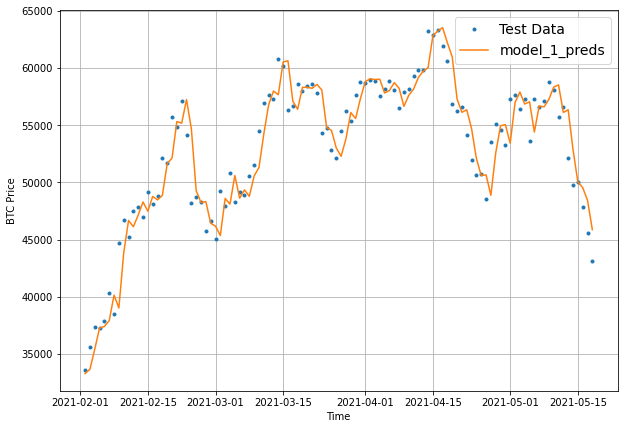

In [58]:
# Let's plot our model 1 predictions
offset = 450
plt.figure(figsize=(10, 7))

# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(timesteps=X_test[-len(test_windows) :], 
                 values = test_labels[:, 0],
                 start = offset, 
                 label="Test Data")

plot_time_series(timesteps = X_test[-len(test_windows) :],
                 values = model_1_preds,
                 start = offset,
                 format = "-",
                 label = "model_1_preds")

> **Resources** : To understand a bit more about the lagging predictions for the above model predictions, please refer to the resources on topic "Autocorrelation"
https://otexts.com/fpp3/acf.html

## Model 2 : Window size = 30, horizon = 1

In [59]:
# Create train and test data for window size 30
WINDOW_SIZE = 30 # use 30 timestamps in past
HORIZON = 1 # predict one step at a time (one day of Bitcoin prices)


In [60]:
# Make windows data with appropriate horizon and window sizes
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [61]:
full_windows.shape, full_labels.shape

((2757, 30), (2757, 1))

In [62]:
# Make train/test windows for the WINDOW_SIZE = 30
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, 
                                                                                full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2205, 552, 2205, 552)

In [63]:
 train_windows.shape, test_windows.shape, train_labels.shape, test_labels.shape

((2205, 30), (552, 30), (2205, 1), (552, 1))

In [64]:
train_windows[:3], train_labels[:3]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  , 123.033  , 124.049  , 125.96116, 125.27966, 125.9275 ,
         126.38333, 135.24199, 133.20333, 142.76333, 137.92333, 142.95166,
         152.55183, 160.33883, 164.31499, 177.63333, 188.29716, 200.70166,
         180.355  , 175.03166, 177.6965 , 187.15983, 192.75666, 197.4    ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  , 124.049  , 125.96116, 125.27966, 125.9275 , 126.38333,
         135.24199, 133.20333, 142.76333, 137.92333, 142.95166, 152.55183,
         160.33883, 164.31499, 177.63333, 188.29716, 200.70166, 180.355  ,
         175.03166, 177.6965 , 187.15983, 192.75666, 197.4    , 196.02499],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  , 125.96116, 125.27966, 125.9275 , 126.38333, 135.24199,
         133.20333, 142.76333, 137.92333, 142.95166, 152.55183, 160.33883,
         164.31499, 177

In [65]:
# Create model 2
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

# Create model_2
model_2 = tf.keras.Sequential([
          layers.Dense(128, activation="relu"),
          layers.Dense(HORIZON)
  ], name="model_2_dense")

# Compile the model
model_2.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam(),
                metrics=["mae"])

# Fit the model
model_2.fit(x = train_windows, 
            y = train_labels,
            epochs = 100,
            batch_size = 128, 
            verbose = 0,
            validation_data = (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [66]:
# Evaluate model 2 on test data
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.9620 - mae: 608.9620


[608.9619750976562, 608.9619750976562]

In [67]:
# Load in the best performing model 
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.9620 - mae: 608.9620


[608.9619750976562, 608.9619750976562]

In [68]:
# Get forecast predictions
model_2_preds = make_preds(model_2, 
                           input_data = test_windows)

In [69]:
model_2_preds.shape, test_labels.shape, tf.squeeze(test_labels).shape

(TensorShape([552]), (552, 1), TensorShape([552]))

In [70]:
# Evaluate  results for model 2 predictions
model_2_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_2_preds)
model_2_results

{'mae': 608.962,
 'mape': 2.7693412,
 'mase': 1.0644715,
 'mse': 1281440.6,
 'rmse': 1132.0073}

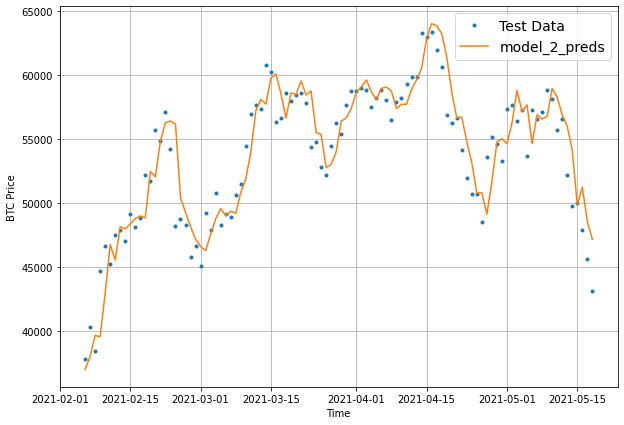

In [71]:
offset = 450
plt.figure(figsize=(10, 7))
# Account for test_window offset when plotting
plot_time_series(timesteps = X_test[-len(test_windows) :], 
                 values = test_labels[:, 0],
                 start = offset, 
                 label="Test Data")

plot_time_series(timesteps = X_test[-len(test_windows) : ],
                 values = model_2_preds,
                 start = offset,
                 format="-",
                 label = "model_2_preds")

## Model 3 : Dense ( Window size = 30, horizon = 7)

In [72]:
# Create train and test data for window size 30
WINDOW_SIZE = 30 # use 30 timestamps in past
HORIZON = 7 # predict 7 step at a time (one day of Bitcoin prices)

In [73]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)


(2751, 2751)

In [74]:
full_windows.shape, full_labels.shape

((2751, 30), (2751, 7))

In [75]:
# Make train/test windows for the WINDOW_SIZE = 30 HORIZON = 7
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows = full_windows, 
                                                                                labels = full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2200, 551, 2200, 551)

In [76]:
train_windows.shape, train_labels.shape

((2200, 30), (2200, 7))

In [77]:
HORIZON, WINDOW_SIZE

(7, 30)

In [78]:
# Create model 3 (same as model_1 except with different data input and output sizes)
import tensorflow as tf
from tensorflow.keras import layers

tf.random.set_seed(42)

# Create the model
model_3 = tf.keras.Sequential([
          layers.Dense(128, activation="relu"),
          layers.Dense(HORIZON) # activation="linear" same as no activation(None)
], name="model_3_dense")

# Compile the model
model_3.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam())

# Fit the model
model_3.fit(train_windows,
            train_labels,
            epochs = 100,
            batch_size = 128,
            verbose = 0,
            validation_data = (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name = model_3.name)])


INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [79]:
# Evaluate model on the test data
model_3.evaluate(test_windows, test_labels)


18/18 [==============================] - 0s 1ms/step - loss: 1340.4274


1340.4273681640625

In [80]:
# Load best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)


18/18 [==============================] - 0s 2ms/step - loss: 1234.8838


1234.8837890625

In [81]:
# Get Model_3 predictions
model_3_preds = make_preds(model = model_3,
                           input_data = test_windows)

In [82]:
model_3_preds[:3]

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[9250.798, 9279.124, 9394.038, 9400.203, 9479.183, 9375.264,
        9302.472],
       [8945.557, 9029.438, 9164.761, 8997.948, 9077.654, 8971.883,
        9081.854],
       [8883.711, 8987.258, 9057.071, 8901.714, 9001.872, 8817.509,
        8971.558]], dtype=float32)>

In [83]:
model_3_preds.shape, test_labels.shape

(TensorShape([551, 7]), (551, 7))

In [84]:
# Evaluate model_3 results
model_3_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_3_preds)
model_3_results["mae"].ndim

1

In [85]:
model_2_results["mae"].ndim

0

In [86]:
tf.reduce_mean(model_3_results["mae"]).numpy()

1234.8837

In [87]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1234.8838


1234.8837890625

## Make our evaluation function work for larger horizons


In [88]:
# Create a function to take in model predictions and truth value and return eveluation metrics

def evaluate_preds(y_true, y_pred) :
  """
  Compute all evaluation metrics
  Returns :
  dictionary with all evaluation metrics values
  """
  # Make sure float32 datatype (for metric calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for different sized metrics (for longer horizons, we want to reduce metrics to a single value)
  if mae.ndim > 0 :
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {
      "mae" : mae.numpy(),
      "mse": mse.numpy(),
      "rmse" : rmse.numpy(),
      "mape" : mape.numpy(),
      "mase": mase.numpy()}

In [89]:
# Recalculate model_3 evaluation aggregated to single value
model_3_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_3_preds)
model_3_results

{'mae': 1234.8837,
 'mape': 5.4874988,
 'mase': 2.1974065,
 'mse': 5393734.5,
 'rmse': 1419.1364}

We've made and evaluated predictions with `model_3` let's visualize, visualize, visualize!

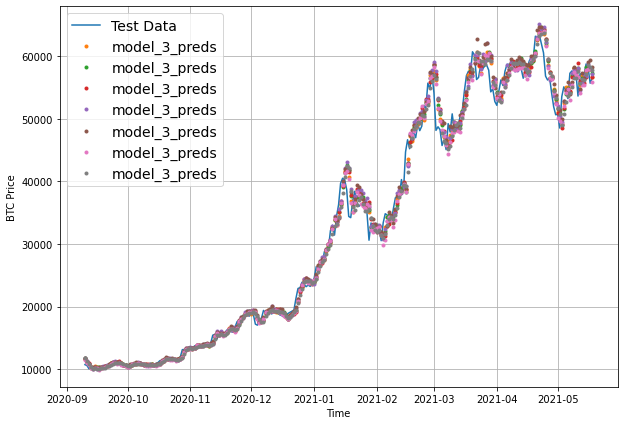

In [90]:
# Plot the model 3 predictions

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps = X_test[- len(test_windows) : ],
                 values = test_labels[:, 0],
                 start = offset, 
                 format="-",
                 label = "Test Data")
plot_time_series(timesteps=X_test[-len(test_windows) :],
                 values = model_3_preds,
                 start = offset,
                 label = "model_3_preds")

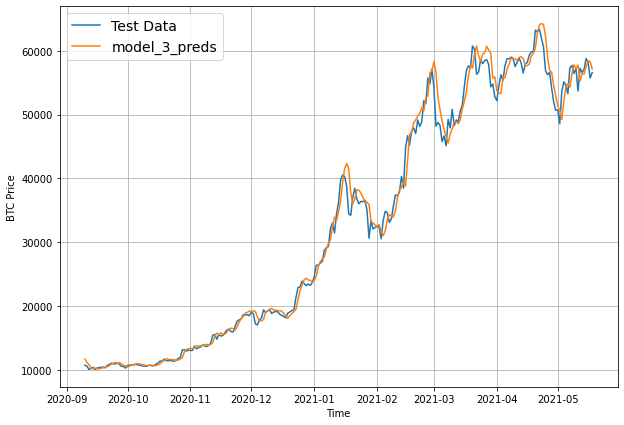

In [91]:
# Plot the model 3 predictions

offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps = X_test[- len(test_windows) : ],
                 values = test_labels[:, 0],
                 start = offset, 
                 format="-",
                 label = "Test Data")
plot_time_series(timesteps=X_test[-len(test_windows) :],
                 values = tf.reduce_mean(model_3_preds, axis=1),
                 start = offset,
                 format="-",
                 label = "model_3_preds")

## Which of our model's performing the best so far?

We have trained a few models, now let's compare them and see how they've gone ...


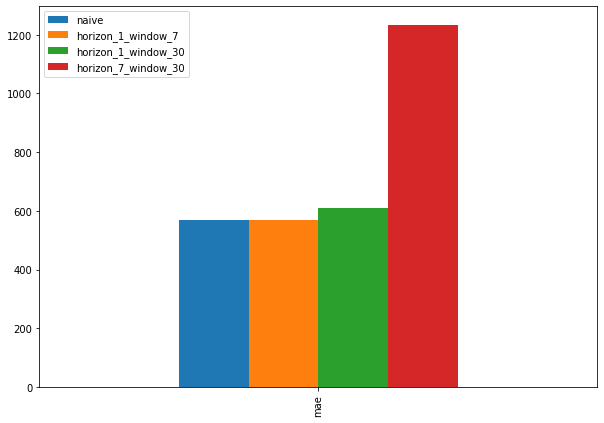

In [92]:
pd.DataFrame({"naive" : naive_results["mae"],
              "horizon_1_window_7" : model_1_results["mae"],
              "horizon_1_window_30" : model_2_results["mae"],
              "horizon_7_window_30" : model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind="bar");


> **Resources**: Why our naive baseline model perform better for time-series steps? Are the predicted prices co-related to past prices. Read this article to get a better understanding on 'Autocorrelation' : https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

## Model 4 : Build a Conv1D

In [93]:
HORIZON = 1 # predict next day of Bitcoin prices
WINDOW_SIZE = 7 # use previous week worth data


In [94]:
# Create windowed data
full_windows, full_labels = make_windows(prices, window_size = WINDOW_SIZE, horizon = HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [95]:
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(2224, 556, 2224, 556)

In [96]:
train_windows.shape, train_labels.shape

((2224, 7), (2224, 1))

We need an input shape of : `(batch_size, timesteps, input_dim)`...

However, out data isn't in that shape yet...

In [97]:
# Check data input shape
train_windows[0].shape # returns (WINDOW_SIZE)

(7,)

In [98]:
# Before we pass our data to the Conv1D layer, we have to reshape it in order to make it work
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

> **Resources** : TensorFlow Lambda function https://www.tensorflow.org/api_docs/python/tf/keras/layers/Lambda

In [99]:
expand_dims_layer = layers.Lambda(lambda x : tf.expand_dims(x, axis = 1)) # add an extra dimension for input_dim

In [100]:
# Test out our lambda layer
print(f"Original shape : {x.shape}") # (WINDOW_SIZE)
print(f"Expanded shape : {expand_dims_layer(x).shape}") # (WINDOW_SIZE, input_dim)
print(f"Original values with expanded shape :\n {expand_dims_layer(x)}")

Original shape : (7,)
Expanded shape : (7, 1)
Original values with expanded shape :
 [[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [101]:
tf.random.set_seed(42)

# Create Conv1D model
model_4 = tf.keras.Sequential([
        layers.Lambda(lambda x : tf.expand_dims(x, axis=1)),
        layers.Conv1D(filters = 128,
                      kernel_size= 5, 
                      strides = 1,
                      padding="causal",  # Our data is temporal , so using padding="causal"
                      activation="relu"),
        layers.Dense(HORIZON)
        ], name="model_4_conv1D")


# Compile the model
model_4.compile(loss="mae", 
                optimizer= tf.keras.optimizers.Adam())

# Fit the model
model_4.fit(x = train_windows, 
            y = train_labels,
            batch_size=128, 
            epochs=100,
            verbose = 1, 
            validation_data = (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name = model_4.name)])

Epoch 1/100
18/18 [==============================] - 27s 12ms/step - loss: 1207.3817 - val_loss: 2320.6218
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 316.2171 - val_loss: 1467.2799
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
Epoch 3/100
18/18 [==============================] - 0s 4ms/step - loss: 192.6853 - val_loss: 1164.7074
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
Epoch 4/100
18/18 [==============================] - 0s 4ms/step - loss: 177.3535 - val_loss: 981.6695
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
Epoch 5/100
18/18 [==============================] - 0s 4ms/step - loss: 172.3466 - val_loss: 960.8708
INFO:tensorflow:Assets written to: model_experiments/model_4_conv1D/assets
Epoch 6/100
18/18 [==============================] - 0s 4ms/step - loss: 171.9754 - val_loss: 950.2026
I

In [102]:
model_4.summary()

Model: "model_4_conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 128)            4608      
_________________________________________________________________
dense_6 (Dense)              (None, 1, 1)              129       
Total params: 4,737
Trainable params: 4,737
Non-trainable params: 0
_________________________________________________________________


In [103]:
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 27ms/step - loss: 610.1541


610.1541137695312

In [104]:
# Load the best performing model_4
model_4 = tf.keras.models.load_model("model_experiments/model_4_conv1D")
model_4.evaluate(test_windows, test_labels)


18/18 [==============================] - 0s 2ms/step - loss: 570.8284


570.8284301757812

In [105]:
# Make predictions
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8851.464, 8754.47 , 8983.927, 8759.671, 8703.626, 8708.294,
       8661.668, 8494.838, 8435.317, 8492.114], dtype=float32)>

In [106]:
# Evaluate predictions
model_4_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_4_preds)
model_4_results

{'mae': 570.8284,
 'mape': 2.5593362,
 'mase': 1.0027875,
 'mse': 1176671.2,
 'rmse': 1084.7448}

In [107]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171744.0,
 'rmse': 1082.4712}

## Model  5 : RNN (LSTM)

Let's build an RNN model for our time series data.
We'll use the same data we created previously.

In [108]:
from tensorflow.keras import layers
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x : tf.expand_dims(x, axis = 1)) (inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
#x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs = inputs, outputs = outputs, name = "model_5_lstm")

# Compile the model
model_5.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam())

# Fit the model
model_5.fit(x = train_windows, 
            y = train_labels,
            epochs= 100,
            batch_size=128,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name = model_5.name)])


Epoch 1/100
18/18 [==============================] - 1s 17ms/step - loss: 2323.6077 - val_loss: 9222.6221
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
Epoch 2/100
18/18 [==============================] - 0s 7ms/step - loss: 695.4739 - val_loss: 1486.0378
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
Epoch 3/100
18/18 [==============================] - 0s 6ms/step - loss: 237.3842 - val_loss: 1298.9087
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
Epoch 4/100
18/18 [==============================] - 0s 6ms/step - loss: 181.9185 - val_loss: 966.6432
INFO:tensorflow:Assets written to: model_experiments/model_5_lstm/assets
Epoch 5/100
18/18 [==============================] - 0s 6ms/step - loss: 173.4023 - val_loss: 970.9296
Epoch 6/100
18/18 [==============================] - 0s 6ms/step - loss: 173.3822 - val_loss: 981.0975
Epoch 7/100
18/18 [==============================] - 0s 5ms/step - loss: 171.9762 - v

In [109]:
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 597.4624


597.46240234375

In [110]:
# Get the best performing model 5 and evaluate on test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_lstm/")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 597.4624


597.46240234375

In [111]:
# Make prediction with our LSTM model
model_5_preds = make_preds(model_5, input_data= test_windows)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8992.637, 8824.648, 9010.125, 8848.681, 8743.077], dtype=float32)>

In [112]:
# Evaluate model 5 predictions
model_5_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                 y_pred = model_5_preds)
model_5_results

{'mae': 597.46234,
 'mape': 2.6910973,
 'mase': 1.0495758,
 'mse': 1275416.0,
 'rmse': 1129.3431}

In [113]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171744.0,
 'rmse': 1082.4712}

**Note** : Because neural networks are such powerful algorithms, they can be used for almost any problem, however that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

## Make a multivariate time-series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Daniel Bourke  or Elon Musk ( :) )tweeted on that day ...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's better feature to use ?


How about the bitcoin halving events?
https://www.cmcmarkets.com/en/learn-cryptocurrencies/bitcoin-halving

In [114]:
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [115]:
# Let's add the bitcoin halving to the dataset

block_reward_1 = 50 # 3 January  2009 - this block reward isn't in our dataset (our dataset start from 2013 Oct 01)
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016 
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [116]:
# Create date ranges of where specific block_reward values should be 
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [117]:
# Add in block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days : block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days :, -1] = block_reward_4

In [118]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-01,123.65499,25
2013-10-02,125.45500,25
2013-10-03,108.58483,25
2013-10-04,118.67466,25
2013-10-05,121.33866,25


In [119]:
bitcoin_prices_block.tail()

,Price,block_reward
Date,,
2021-05-14,49764.132082,6.25
2021-05-15,50032.693137,6.25
2021-05-16,47885.625255,6.25
2021-05-17,45604.615754,6.25
2021-05-18,43144.471291,6.25


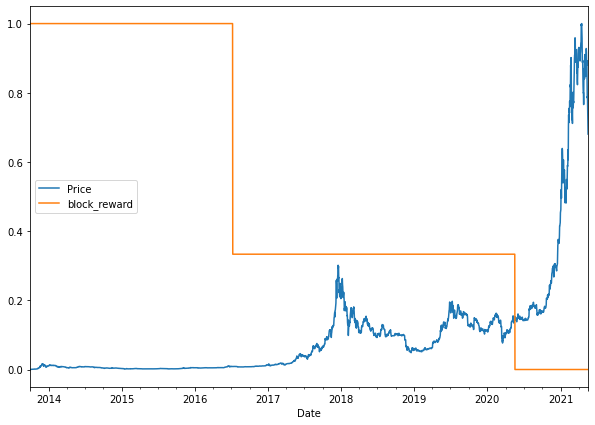

In [120]:
# Plot the block reward vs price over time.
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                            columns = bitcoin_prices_block.columns,
                                     index = bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize = (10, 7));

In [121]:
scaled_price_block_df.head()

,Price,block_reward
Date,,
2013-10-01,0.000238,1.0
2013-10-02,0.000267,1.0
2013-10-03,0.000000,1.0
2013-10-04,0.000160,1.0
2013-10-05,0.000202,1.0


## Making a windowed dataset with pandas

Previously, we turned our univariate time series into windowed dataset using the helper functions above. 

However, since we've got multivariate data, these functions won't work.
Not to worry, we can use `pandas.DataFrame.shift()` method to window our multivariate data.
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.shift.html

In [122]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [123]:
# Make a copy of the Bitcoin historical data with block reward feature
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed column
for i in range(WINDOW_SIZE) : # shift values for each step in WINDOW_SIZE
  bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed["Price"].shift(periods = i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-01,123.65499,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,25,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,25,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,25,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,25,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN
2013-10-06,120.65533,25,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN
2013-10-07,121.79500,25,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499,NaN
2013-10-08,123.03300,25,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500,123.65499
2013-10-09,124.04900,25,123.03300,121.79500,120.65533,121.33866,118.67466,108.58483,125.45500


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [124]:
# Create X (windows) and y(horizons) features
X = bitcoin_prices_windowed.dropna().drop("Price", axis = 1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()["Price"].astype(np.float32)

X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [125]:
y.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

In [126]:
# Make train and test sets using indexing
split_size = int(len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size :]

len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [127]:
X_train.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-08,25.0,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002,123.654991
2013-10-09,25.0,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831,125.455002
2013-10-10,25.0,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660,108.584831
2013-10-11,25.0,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661,118.674660
2013-10-12,25.0,125.279663,125.961159,124.049004,123.032997,121.794998,120.655327,121.338661


In [128]:
y_train.head()

Date
2013-10-08    123.032997
2013-10-09    124.049004
2013-10-10    125.961159
2013-10-11    125.279663
2013-10-12    125.927498
Name: Price, dtype: float32

## Model 6 : Dense(multivariate time series)


In [129]:
tf.random.set_seed(42)

# Make multivariate time series model
model_6 = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            #layers.Dense(128, activation="relu"),
            layers.Dense(HORIZON)
], name="model_6_dense_multivariate")

# Compile
model_6.compile(loss="mae",
                optimizer = tf.keras.optimizers.Adam())

# Fit the model
model_6.fit(x = X_train,
            y = y_train,
            epochs = 100,
            batch_size = 128,
            verbose = 1,
            validation_data = (X_test, y_test),
            callbacks=[create_model_checkpoint(model_name = model_6.name)])


Epoch 1/100
18/18 [==============================] - 0s 10ms/step - loss: 1234.6805 - val_loss: 2061.9075
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 2/100
18/18 [==============================] - 0s 3ms/step - loss: 351.5054 - val_loss: 1908.6731
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 3/100
18/18 [==============================] - 0s 3ms/step - loss: 235.4153 - val_loss: 1329.0583
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 4/100
18/18 [==============================] - 0s 3ms/step - loss: 208.6112 - val_loss: 1102.1342
INFO:tensorflow:Assets written to: model_experiments/model_6_dense_multivariate/assets
Epoch 5/100
18/18 [==============================] - 0s 3ms/step - loss: 196.5770 - val_loss: 1107.8473
Epoch 6/100
18/18 [==============================] - 0s 3ms/step - loss: 187.2244 - val_loss: 1036.1720
INFO:tensorflow:Assets wri

In [130]:
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 639.6246


639.6245727539062

In [131]:
# Load in best performing model
model_6 = tf.keras.models.load_model("model_experiments/model_6_dense_multivariate/")
model_6.evaluate(X_test, y_test)

18/18 [==============================] - 0s 1ms/step - loss: 568.0361


568.0360717773438

In [132]:
# Make predictions with multivariate model
model_6_preds = tf.squeeze(model_6.predict(X_test))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8849.693 , 8777.459 , 9053.712 , 8753.832 , 8731.5205, 8777.638 ,
       8673.611 , 8509.444 , 8475.512 , 8533.936 ], dtype=float32)>

In [133]:
# Evaluate predictions to get eval metrics
model_6_results = evaluate_preds(y_true = y_test,
                                 y_pred = model_6_preds)
model_6_results

{'mae': 568.036,
 'mape': 2.546599,
 'mase': 0.99788195,
 'mse': 1166216.0,
 'rmse': 1079.9148}

In [134]:
model_1_results

{'mae': 568.9511,
 'mape': 2.5448983,
 'mase': 0.99948955,
 'mse': 1171744.0,
 'rmse': 1082.4712}

In [135]:
naive_results

{'mae': 567.9802,
 'mape': 2.516525,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Model 7 : N-BEATS algorithm

Let's now build the biggest baddest (though maybe not the baddest, as in, it perform really well...) time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in Figure 1 from the following paper : https://arxiv.org/pdf/1905.10437.pdf

Why ?
* This will allow us to practice replicating a paper with TensorFlow code
* We will see how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture.
* Potentially get state of the art results for our problem

### Building and testing the N-BEATS block layer


Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layers and models in TensorFlow, we  can  use subclassing :
https://www.tensorflow.org/guide/keras/custom_layers_and_models

In [136]:
# Create N-Beats Block custom layer
class NBeatsBlock(tf.keras.layers.Layer) :
  def __init__(self,
               input_size : int,
               theta_size : int,
               horizon : int, 
               n_neurons : int, 
               n_layers : int,
               **kwargs): # the **kwargs take care of all the arguments for the parent class (input_shape, trainable, name ...)
    super().__init__(**kwargs)
    self.input_size = input_size
    self.theta_size = theta_size
    self.horizon = horizon
    self.n_neurons = n_neurons
    self.n_layers = n_layers

    # Block contains stack of 4 fully connected layers each has ReLU activation
    self.hidden  = [tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)]
    #Output of block is a theta layer with linerar activation
    self.theta_layer = tf.keras.layers.Dense(theta_size, activation="linear", name="theta")

  def call(self, inputs) :
    x = inputs
    for layer in self.hidden :
      x = layer(x)
    theta = self.theta_layer(x)
    # Output the backcast and forecast from theta
    backcast, forecast = theta[:, :self.input_size], theta[:, -self.horizon:]
    return backcast, forecast



Let's test our NBeatsBlock class.
To do we'll make some dummay inputs and outputs.

In [137]:
# Set up dummy NBeatsBlock layer to represent inputs and outputs
tf.random.set_seed(42)
dummy_nbeasts_block_layer = NBeatsBlock(input_size=WINDOW_SIZE,
                                        theta_size = WINDOW_SIZE + HORIZON, # backcast + forecast
                                        horizon = HORIZON,
                                        n_neurons = 128,
                                        n_layers = 4)

In [138]:
# Create dummy inputs (have to be same size as input_size)
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) +1,  axis=0) # input shaep to the model has to reflect dense layer input requirments (ndim = 2)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [139]:
# Pass dummy inputs to dummy NBeatsBlock layer
backcast, forecast = dummy_nbeasts_block_layer(dummy_inputs)

# These are the activation outpts of the theta layer(they'll be random due to no training of the model)
print(f"Backcast : {tf.squeeze(backcast.numpy())}")
print(f"Forecast : {tf.squeeze(forecast.numpy())}")

Backcast : [ 0.07960155  0.3251205  -0.8428683  -0.69389856 -0.31720546 -0.56987345
 -0.6396661 ]
Forecast : 1.0071648359298706


### Preparing data for the N-Beats algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf data guide :
https://www.tensorflow.org/guide/data_performance



In [140]:
HORIZON = 1
WINDOW_SIZE = 7

In [141]:
# Create N-Beats data inputs (N-Beats work with univariate time series)
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [142]:
# Add windowed column
bitcoin_prices_nbeats = bitcoin_prices.copy()
for i in range(WINDOW_SIZE) :
  bitcoin_prices_nbeats[f"Prices+{i+1}"] = bitcoin_prices_nbeats["Price"].shift(periods = i + 1)

bitcoin_prices_nbeats.head()

,Price,Prices+1,Prices+2,Prices+3,Prices+4,Prices+5,Prices+6,Prices+7
Date,,,,,,,,
2013-10-01,123.65499,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-02,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-03,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN,NaN
2013-10-04,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN,NaN
2013-10-05,121.33866,118.67466,108.58483,125.45500,123.65499,NaN,NaN,NaN


In [143]:
# Make features and labels
X = bitcoin_prices_nbeats.dropna().drop("Price", axis=1)
y = bitcoin_prices_nbeats.dropna()["Price"] 

# Make train and test sets
split_size = int (len(X) * 0.8)
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size :], y[split_size : ]
len(X_train), len(y_train), len(X_test), len(y_test)

(2224, 2224, 556, 556)

In [144]:
# Time to make our dataset performant using tf.data API

train_features_dataset = tf.data.Dataset.from_tensor_slices(X_train)
train_labels_dataset = tf.data.Dataset.from_tensor_slices(y_train)

test_features_dataset = tf.data.Dataset.from_tensor_slices(X_test)
test_labels_dataset = tf.data.Dataset.from_tensor_slices(y_test)

# Combine labels and features by zipping together -> (fetaures, labels)
train_dataset = tf.data.Dataset.zip((train_features_dataset, train_labels_dataset))
test_dataset = tf.data.Dataset.zip((test_features_dataset, test_labels_dataset))

# Batch and prefetch
BATCH_SIZE = 1024
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [145]:
len(train_dataset), len(test_dataset)

(3, 1)

In [146]:
train_dataset, test_dataset

(<PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>,
 <PrefetchDataset shapes: ((None, 7), (None,)), types: (tf.float64, tf.float64)>)

### Setting up hyperparameters for N-BEATS algorithm

The N-Beats algorithm has a fair few numbers of parameters, many of them can be found in Table 18 : https://arxiv.org/pdf/1905.10437.pdf

In [147]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS  = 4
N_STACKS = 30

INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON  # total includes forecast (Horizon) and backcast(Input_size)

INPUT_SIZE, THETA_SIZE

(7, 8)

### Getting ready for residual connection

Before we can craft our N-BEATS model, we need two layers for the residual connection (substract and add)

The N-Beats algorithm uses double residual stacking to help train its deeper architecture (section 3.2 of N-Beats paper)

> **Resources** : For more on residual connection see :
* https://en.wikipedia.org/wiki/Residual_neural_network
* https://en.wikipedia.org/wiki/Vanishing_gradient_problem
* https://arxiv.org/abs/1512.03385
* https://paperswithcode.com/method/resnet

In [148]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2  = tf.range(10)

#Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

#Add
added  = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors : {tensor_1.numpy()} & {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added : {added.numpy()}")

Input tensors : [10 11 12 13 14 15 16 17 18 19] & [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added : [10 12 14 16 18 20 22 24 26 28]


### Building , compiling and fitting the N-BEATS algorithm


1. Setup an instance of N-Beats block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecasts for the model with the layer created in (1)
4. Use for-loops to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcasts and block-level forecasts
6. Create the double residual stacking using substract and add layers
7. Put the models inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with out other mdoels) and Adam optimizer with default setting as per section 5.2 of N-BEATS paper.
9. Fit the N-BEATS for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks :
 * Early stopping - because the model will be training for so long, we'll stop it early if it stops improving
 * Reduce LR on Plateau - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time(take smaller steps towards best performance)